### 本スクリプトの実行にはGPUの利用を推奨します。

Epoch 1/100, Loss: 0.7366
Epoch 2/100, Loss: 0.3285
Epoch 3/100, Loss: 0.2783
Epoch 4/100, Loss: 0.2557
Epoch 5/100, Loss: 0.2137
Epoch 6/100, Loss: 0.1945
Epoch 7/100, Loss: 0.1789
Epoch 8/100, Loss: 0.1830
Epoch 9/100, Loss: 0.1778
Epoch 10/100, Loss: 0.1684
Epoch 11/100, Loss: 0.1651
Epoch 12/100, Loss: 0.1616
Epoch 13/100, Loss: 0.1585
Epoch 14/100, Loss: 0.1534
Epoch 15/100, Loss: 0.1429
Epoch 16/100, Loss: 0.1427
Epoch 17/100, Loss: 0.1504
Epoch 18/100, Loss: 0.1373
Epoch 19/100, Loss: 0.1412
Epoch 20/100, Loss: 0.1379
Epoch 21/100, Loss: 0.1377
Epoch 22/100, Loss: 0.1344
Epoch 23/100, Loss: 0.1392
Epoch 24/100, Loss: 0.1384
Epoch 25/100, Loss: 0.1347
Epoch 26/100, Loss: 0.1315
Epoch 27/100, Loss: 0.1311
Epoch 28/100, Loss: 0.1361
Epoch 29/100, Loss: 0.1259
Epoch 30/100, Loss: 0.1277
Epoch 31/100, Loss: 0.1278
Epoch 32/100, Loss: 0.1274
Epoch 33/100, Loss: 0.1290
Epoch 34/100, Loss: 0.1300
Epoch 35/100, Loss: 0.1370
Epoch 36/100, Loss: 0.1227
Epoch 37/100, Loss: 0.1252
Epoch 38/1

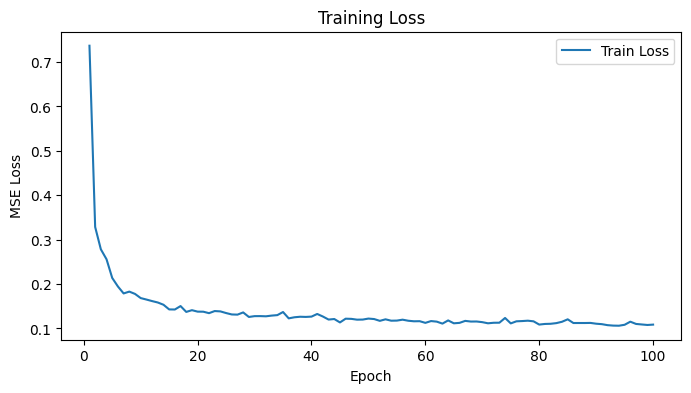

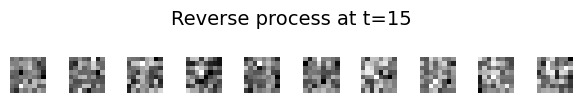

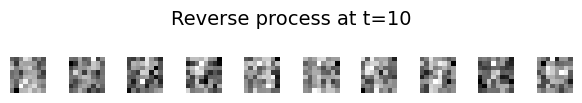

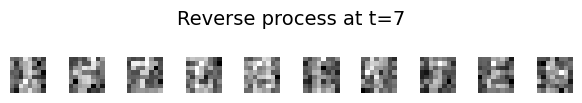

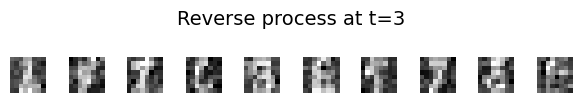

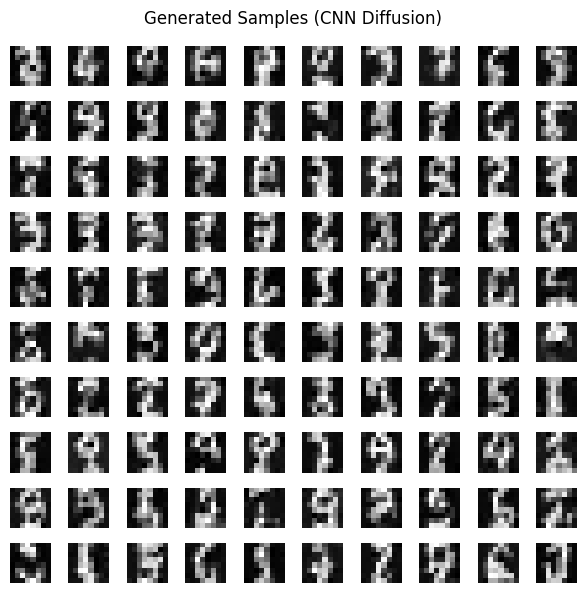

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# 生成parameter
TIME_EMB_DIM=16
HIDDEN_CHANNELS=64
T = 40

# 乱数シードの設定（再現性のため）
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

os.makedirs("fig", exist_ok=True)

# --- デバイス設定（GPUがあればGPUを使う） ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- データのロードと前処理 ---
digits = load_digits()
data = digits.data / 16.0                    # [N, 64] → [0,1] に正規化
data = torch.tensor(data, dtype=torch.float32)
data = data.view(-1, 1, 8, 8).to(device)     # [N,1,8,8] に変形して GPU へ
targets = torch.tensor(digits.target, dtype=torch.int64).to(device)

dataset = TensorDataset(data, targets)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# --- コサインスケーリングによるβスケジュール ---
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi / 2) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
    return np.clip(betas, 0, 0.999)


betas = torch.tensor(cosine_beta_schedule(T), dtype=torch.float32, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# --- forward diffusion: x0 -> xt ---
def forward_diffusion_sample(x_0, t):
    """
    x_0: (B,1,8,8)
    t:   (B,), 
    B = batch size
    """
    noise = torch.randn_like(x_0)
    a_t = sqrt_alphas_cumprod[t].view(-1,1,1,1)
    om_a_t = sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1)
    x_t = a_t * x_0 + om_a_t * noise
    return x_t, noise

# --- 時刻埋め込みの実装 ---
class TimeEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.linear1 = nn.Linear(1, embed_dim)
        self.relu    = nn.ReLU()
        self.linear2 = nn.Linear(embed_dim, embed_dim)
    def forward(self, t):
        t = t.unsqueeze(1).float()          # (B,1)
        h = self.relu(self.linear1(t))
        return self.linear2(h)              # (B, time_emb_dim)

# --- CNNベースの拡散モデル定義 ---
class CNNDiffusionModel(nn.Module):
    def __init__(self, input_channels, time_emb_dim, hidden_channels):
        super().__init__()
        self.time_embed = TimeEmbedding(time_emb_dim)
        # 時刻埋め込みを 8x8 のマップに変換
        self.fc_time = nn.Linear(time_emb_dim, 8*8)
        # ノイズ予測用の U-Net風ではない簡易 CNN
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels + 1, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, input_channels,    kernel_size=3, padding=1),
        )

    def forward(self, x, t):
        """
        x: (B,1,8,8)  ノイズ付加済み画像（Bはバッチサイズ）
        t: (B,)       拡散ステップ時刻（バッチごとの整数ステップ）
        """
        # 時刻埋め込み→マップ化
        t_emb = self.time_embed(t)                         # (B, time_emb_dim)
        t_map = self.fc_time(t_emb).view(-1, 1, 8, 8)      # (B,1,8,8)
        # 画像と時刻マップをチャネル方向に連結
        x_input = torch.cat([x, t_map], dim=1)             # (B,2,8,8)
        return self.conv(x_input)                         # (B,1,8,8) のノイズ予測

# --- モデル初期化と最適化 ---
model = CNNDiffusionModel(input_channels=1, # 白黒画像なので1 channel
                          time_emb_dim=TIME_EMB_DIM,
                          hidden_channels=HIDDEN_CHANNELS).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

# --- 学習ループ ---
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for x0, _ in dataloader:
        B = x0.size(0)
        t = torch.randint(0, T, (B,), device=device)
        x_t, noise = forward_diffusion_sample(x0, t)
        noise_pred = model(x_t, t)
        loss = mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * B
    avg_loss = total_loss / len(dataloader.dataset)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# --- 損失のプロット ---
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

DDPM = True


# --- 各tで10枚ずつを行列形式（1x10）で表示 ---
@torch.no_grad()
def show_reverse_steps_grid(model, n_samples=10, steps=[3, 7, 10], DDPM=True):
    model.eval()
    x = torch.randn(n_samples, 1, 8, 8, device=device)
    saved_images = {}

    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        eps_theta = model(x, t_batch)

        beta_t  = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alphas_cumprod[t]
        sqrt_ab_t = torch.sqrt(alpha_bar_t)
        sqrt_ab_prev = torch.sqrt(alphas_cumprod[t-1] if t > 0 else torch.tensor(1.0, device=device))
        sqrt_om_ab_t = torch.sqrt(1 - alpha_bar_t)

        if DDPM:
            sqrt_recip_alpha = torch.sqrt(1.0 / alpha_t)
            x = sqrt_recip_alpha * (x - (beta_t / sqrt_om_ab_t) * eps_theta)
            if t > 0:
                noise = torch.randn_like(x)
                sigma_t = torch.sqrt(beta_t)
                x = x + sigma_t * noise
        else:
            pred_x0 = (x - sqrt_om_ab_t * eps_theta) / torch.sqrt(alpha_t)
            x = sqrt_ab_prev * pred_x0 + torch.sqrt(1 - alphas_cumprod[t - 1] if t > 0 else 0) * eps_theta

        if t in steps:
            saved_images[t] = x.clone().cpu()

    # 各tごとに10枚をプロット
    for t in saved_images.keys():
        imgs = saved_images[t]  # shape: (10,1,8,8)
        plt.figure(figsize=(6, 1))
        for i in range(n_samples):
            plt.subplot(1, 10, i + 1)
            plt.imshow(imgs[i, 0], cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Reverse process at t={t}", fontsize=14)
        plt.tight_layout()
        plt.savefig(f"fig/DF_t{t}.png")        
        plt.show()

      
# --- 表示呼び出し ---
show_reverse_steps_grid(model, n_samples=10, steps=[3, 7, 10, 15], DDPM=DDPM)



# --- 逆拡散によるサンプリング ---
@torch.no_grad()
def sample_images(model, n_samples, DDPM=True):
    model.eval()
    x = torch.randn(n_samples, 1, 8, 8, device=device)

    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        eps_theta = model(x, t_batch)

        beta_t  = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alphas_cumprod[t]
        sqrt_ab_t = torch.sqrt(alpha_bar_t)
        sqrt_ab_prev = torch.sqrt(alphas_cumprod[t-1] if t>0 else torch.tensor(1.0, device=device))
        sqrt_om_ab_t = torch.sqrt(1 - alpha_bar_t)

        if DDPM:
            # —— DDPM 更新 —— 
            # x_{t-1} = 1/√α_t ( x_t − (β_t / √(1−ᾱ_t)) εθ ) + σ_t η
            sqrt_recip_alpha = torch.sqrt(1.0/alpha_t)
            x = sqrt_recip_alpha * (x - (beta_t / sqrt_om_ab_t) * eps_theta)
            if t > 0:
                noise = torch.randn_like(x)
                sigma_t = torch.sqrt(beta_t)
                x = x + sigma_t * noise

        else:
            # —— DDIM 更新 —— 
            # 1) 元画像予測
            pred_x0 = (x - sqrt_om_ab_t * eps_theta) / torch.sqrt(alpha_t)
            # 2) 決定論的更新
            x = sqrt_ab_prev * pred_x0 + torch.sqrt(1 - alphas_cumprod[t-1] if t>0 else 0) * eps_theta
        
    return x


# --- 生成結果の表示 ---
samples = sample_images(model, n_samples=100).cpu().numpy()
plt.figure(figsize=(6,6))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(samples[i,0], cmap='gray')
    plt.axis('off')
plt.suptitle('Generated Samples (CNN Diffusion)')
plt.tight_layout()
plt.savefig("fig/DF_t0.png")
plt.show()


以下に、**DDPM**（Denoising Diffusion Probabilistic Model）と**DDIM**（Denoising Diffusion Implicit Models）の更新式を、数式と対応するソースコードで対比して示します。

---

## 1. DDPM の更新

### 数式

ステップ $t$ から $t-1$ への逆拡散は、まず平均項を計算し、最後にノイズを再注入します：

$$
\begin{aligned}
\mu_{\theta}(x_t, t) &= \frac{1}{\sqrt{\alpha_t}}\Bigl(x_t - \frac{\beta_t}{\sqrt{1 - \bar\alpha_t}}\,\varepsilon_\theta(x_t, t)\Bigr),\\
x_{t-1} &= \mu_{\theta}(x_t, t)\;+\;\sigma_t\,\eta,\quad \eta\sim\mathcal{N}(0,I),
\end{aligned}
$$

ここで

* $\alpha_t = 1 - \beta_t$,
* $\bar\alpha_t = \prod_{i=1}^t \alpha_i$,
* $\sigma_t = \sqrt{\beta_t}$（または別定義の場合あり）、
* $\varepsilon_\theta$ はモデルが予測するノイズです。

---

### コード（DDPM 部分）

```python
# DDPM=True のときのサンプリング部分
sqrt_recip_alpha = torch.sqrt(1.0 / alpha_t)
sqrt_one_minus_ab = torch.sqrt(1.0 - alphas_cumprod[t])

# 平均項の計算
x = sqrt_recip_alpha * (x - (beta_t / sqrt_one_minus_ab) * eps_theta)

# ノイズ再注入
if t > 0:
    noise = torch.randn_like(x)
    sigma_t = torch.sqrt(beta_t)
    x = x + sigma_t * noise
```

---

## 2. DDIM の更新

### 数式

DDIM ではノイズを再注入せず、元画像の推定 $\hat x_0$ を中間変数として直接決定論的に更新します：

$$
\begin{aligned}
\hat x_0 &= \frac{x_t - \sqrt{1 - \bar\alpha_t}\,\varepsilon_\theta(x_t, t)}{\sqrt{\alpha_t}},\\
x_{t-1} &= \sqrt{\bar\alpha_{t-1}}\,\hat x_0 \;+\;\sqrt{1 - \bar\alpha_{t-1}}\,\varepsilon_\theta(x_t, t).
\end{aligned}
$$

ここで $\bar\alpha_{t-1} = \prod_{i=1}^{t-1}\alpha_i$ です。

---

### コード（DDIM 部分）

```python
# DDPM=False（DDIM）のときのサンプリング部分
# 1) 元画像の予測
alpha_bar_t      = alphas_cumprod[t]
sqrt_ab_t        = torch.sqrt(alpha_bar_t)
sqrt_om_ab_t     = torch.sqrt(1 - alpha_bar_t)
pred_x0 = (x - sqrt_om_ab_t * eps_theta) / torch.sqrt(alpha_t)

# 2) 決定論的更新
alpha_bar_prev      = alphas_cumprod[t-1] if t>0 else torch.tensor(1.0, device=device)
sqrt_ab_prev        = torch.sqrt(alpha_bar_prev)
sqrt_om_ab_prev     = torch.sqrt(1 - alpha_bar_prev)
x = sqrt_ab_prev * pred_x0 + sqrt_om_ab_prev * eps_theta
```

---

### 対比まとめ

|                | DDPM                        | DDIM                                    |
| -------------- | --------------------------- | --------------------------------------- |
| **ノイズ注入**      | 毎ステップ $\sigma_t\,\eta$ を再注入 | 注入しない（決定論的）                             |
| **中間変数**       | 直接 $x_{t-1}$ を計算            | まず $\hat x_0$ を推定し、それを使って $x_{t-1}$ を算出 |
| **多様性 vs 再現性** | ランダムノイズによる多様性あり             | 再現的・高速サンプリング                            |

このように、**DDPM** は確率的にノイズを再注入することで多様なサンプルを得るのに対し、**DDIM** はノイズ再注入を省いて決定論的に更新することで、同じ初期ノイズから常に同じサンプルを高速に生成できる点が特徴です。
